In [1]:
from numpy import ones, linspace, sqrt, concatenate, asarray, inf
from numpy_sugar import ddot
from numpy.random import RandomState
from numpy_sugar.linalg import economic_qs, economic_qs_linear, economic_svd
from glimix_core.lmm import LMM
from chiscore import davies_pvalue

In [2]:
from cellregmap import CellRegMap, run_association, run_association_fast, run_interaction, estimate_betas

In [3]:
random = RandomState(1)
n = 30                               # number of samples (cells)
p = 5                                # number of individuals
k = 4                                # number of contexts
y = random.randn(n, 1)               # outcome vector (expression phenotype, one gene only)
C = random.randn(n, k)               # context matrix (cells by contexts/factors)
W = ones((n, 1))                     # intercept (covariate matrix)
hK = random.randn(n, p)              # decomposition of kinship matrix (K = hK @ hK.T)
g = 1.0 * (random.rand(n, 1) < 0.2)  # SNP vector

In [4]:
import time
import matplotlib.pyplot as plt

In [5]:
########################################################
########################################################
########################################################

In [6]:
########################################################
############## Association Test

In [7]:
###### Fit null model
# crm = CellRegMap(y=y, W=W, C=C, hK=hK)

In [8]:
start_time = time.time()
rhos = linspace(0, 1, 11)
print("--- %s seconds ---" % (time.time() - start_time))

--- 0.00025653839111328125 seconds ---


In [9]:
rhos

array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])

In [10]:
# pick one value of rho as example

In [11]:
rho = rhos[0]
rho

0.0

In [12]:
a = sqrt(rho)
b = sqrt(1 - rho)
[a,b]

[0.0, 1.0]

In [13]:
start_time = time.time()
hS = concatenate([a * C] + [b * hK], axis=1)
print("--- %s seconds ---" % (time.time() - start_time))

--- 0.0004143714904785156 seconds ---


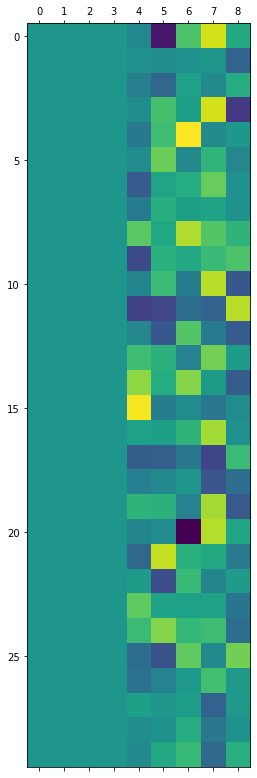

In [14]:
plt.matshow(hS)

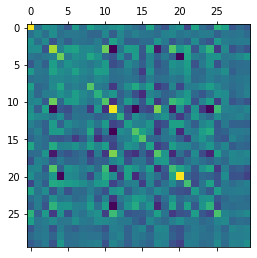

In [15]:
plt.matshow(hS @ hS.T)

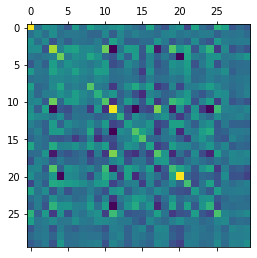

In [16]:
# just checking this is the same
M = rho*C @ C.T + (1-rho)*(hK @ hK.T)
plt.matshow(M)

In [17]:
# rank = 9: 4 contexts + 5 individuals
# n cells = 30
hS.shape

(30, 9)

In [18]:
S = hS @ hS.T
S.shape

(30, 30)

In [19]:
start_time = time.time()
QS = economic_qs_linear(hS, return_q1=False)
print("--- %s seconds ---" % (time.time() - start_time))

--- 0.32024264335632324 seconds ---


In [20]:
# eigenvectors
Q = QS[0][0]
Q.shape

(30, 9)

In [21]:
# eigenvalues
L = QS[1]
L.shape

(9,)

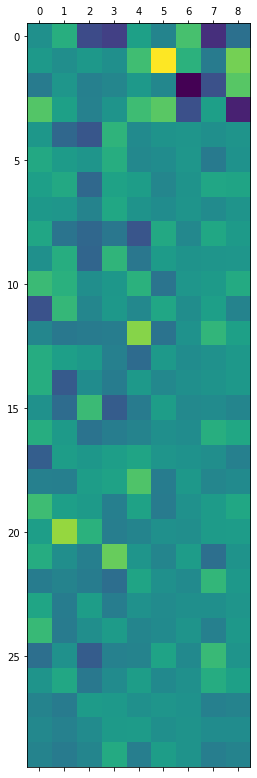

In [22]:
plt.matshow(Q)

In [23]:
###### Run association for specified genotypes
# crm.scan_association_fast(g)

In [24]:
# again looping over rhos, 
# for each row load the corresponding QS computed before
# here just using for rho=0.4 as above

In [25]:
start_time = time.time()
lmm = LMM(y, W, QS, restricted=False)
print("--- %s seconds ---" % (time.time() - start_time))

--- 0.003869295120239258 seconds ---


In [26]:
start_time = time.time()
lmm.fit(verbose=False)
print("--- %s seconds ---" % (time.time() - start_time))

--- 0.01364898681640625 seconds ---


In [27]:
# let us pretend this is the best lmm (i.e. this value of rho corresponds to max likelihood value)

In [28]:
start_time = time.time()
null_lmm = lmm
print("--- %s seconds ---" % (time.time() - start_time))

--- 9.679794311523438e-05 seconds ---


In [29]:
start_time = time.time()
flmm = lmm.get_fast_scanner()
print("--- %s seconds ---" % (time.time() - start_time))

--- 0.00041604042053222656 seconds ---


In [30]:
start_time = time.time()
alt_lmls = flmm.fast_scan(g, verbose=False)['lml']
print("--- %s seconds ---" % (time.time() - start_time))

--- 0.0020856857299804688 seconds ---


In [31]:
def lrt_pvalues(null_lml, alt_lmls, dof=1):
    from numpy import clip
    from numpy_sugar import epsilon
    from scipy.stats import chi2

    lrs = clip(-2 * null_lml + 2 * asarray(alt_lmls, float), epsilon.super_tiny, inf)
    pv = chi2(df=dof).sf(lrs)
    return clip(pv, epsilon.super_tiny, 1 - epsilon.tiny)

In [32]:
start_time = time.time()
pvalues = lrt_pvalues(null_lmm.lml(), alt_lmls, dof=1)
print("--- %s seconds ---" % (time.time() - start_time))

--- 0.001775503158569336 seconds ---


In [33]:
pvalues

array([0.74595695])

In [34]:
## compared to association runner
run_association(y=y, W=W, E=C, hK=hK, G=g)[0]

100%|██████████| 1/1 [00:00<00:00, 98.99it/s]


array([0.74236452])

In [35]:
## compared to association runner (fast)
run_association_fast(y=y, W=W, E=C, hK=hK, G=g)[0]

array([0.74855415])

In [36]:
## compared to two steps association (fast) - identical to this one
crm = CellRegMap(y=y, W=W, E=C, hK=hK)
crm.scan_association_fast(g)[0]

array([0.74595695])

In [37]:
# not fast
crm.scan_association(g)[0]

100%|██████████| 1/1 [00:00<00:00, 105.13it/s]


array([0.74594644])

In [38]:
########################################################
########################################################
########################################################

In [39]:
########################################################
############## Interaction Test

In [40]:
###### get L values
# Ls = get_L_values(hK, C)

In [41]:
start_time = time.time()
[U, S, _] = economic_svd(C)
print("--- %s seconds ---" % (time.time() - start_time))

--- 0.00039386749267578125 seconds ---


In [42]:
U.shape

(30, 4)

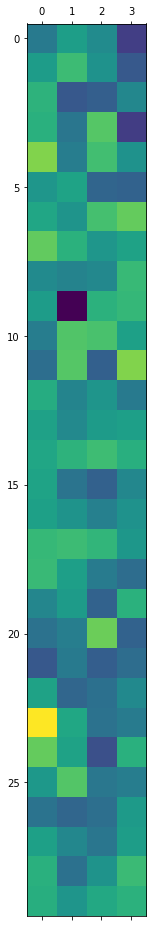

In [43]:
plt.matshow(U)

In [44]:
S.shape

(4,)

In [45]:
start_time = time.time()
us = U * S
print("--- %s seconds ---" % (time.time() - start_time))

--- 0.00011134147644042969 seconds ---


In [46]:
start_time = time.time()
Ls = [ddot(us[:,i], hK) for i in range(us.shape[1])]
print("--- %s seconds ---" % (time.time() - start_time))

--- 0.0002219676971435547 seconds ---


In [47]:
# one per context
len(Ls)

4

In [48]:
# n cells X n individuals
Ls[0].shape

(30, 5)

In [49]:
###### Fit null model
# crm = CellRegMap(y=y, W=W, C=C, Ls=Ls)

In [50]:
# rhos, a, b as above (rho=0.4)

In [51]:
start_time = time.time()
hS = concatenate([a * C] + [b * L for L in Ls], axis=1)
print("--- %s seconds ---" % (time.time() - start_time))

--- 0.0001983642578125 seconds ---


In [52]:
# rank = 24: 4 contexts + (5 individuals)*4
# n cells = 30
hS.shape

(30, 24)

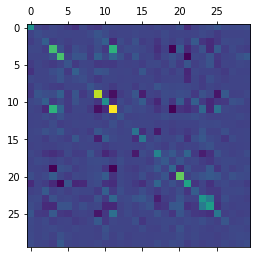

In [53]:
plt.matshow(hS @ hS.T)

In [54]:
start_time = time.time()
QS = economic_qs_linear(hS, return_q1=False)
print("--- %s seconds ---" % (time.time() - start_time))

--- 0.0004267692565917969 seconds ---


In [55]:
# eigenvectors
Q = QS[0][0]
Q.shape

(30, 24)

In [56]:
# eigenvalues
L = QS[1]
L.shape

(24,)

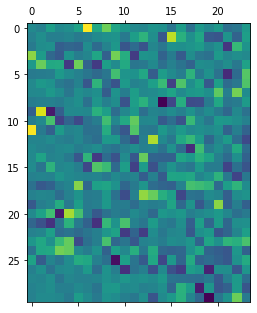

In [57]:
plt.matshow(Q)

In [58]:
###### Run GxC interaction for specified genotypes
# crm.scan_interaction(g)

In [59]:
# in this example with only have one SNP, normally we'd need to loop over them
# differently from the association test above where the null model is in common, 
# here a different null needs to be built every time

In [60]:
# add SNP to fixed effects (accounting for persistent effects of the SNP under the null)
X = concatenate((W, g), axis=1)
X.shape

(30, 2)

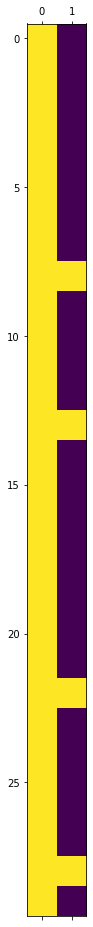

In [61]:
# ones | geno
plt.matshow(X)

In [62]:
start_time = time.time()
lmm = LMM(y, W, QS, restricted=False)
print("--- %s seconds ---" % (time.time() - start_time))

--- 0.0004725456237792969 seconds ---


In [63]:
start_time = time.time()
lmm.fit(verbose=False)
print("--- %s seconds ---" % (time.time() - start_time))

--- 0.010444402694702148 seconds ---


In [67]:
Q0 = QS[0][0]
S0 = QS[1]

In [69]:
from cellregmap._math import PMat, QSCov, ScoreStatistic

In [70]:
start_time = time.time()
qscov = QSCov(
                Q0,
                S0,
                lmm.v0,  # 𝓋₁
                lmm.v1,  # 𝓋₂
            )
print("--- %s seconds ---" % (time.time() - start_time))

--- 0.00016069412231445312 seconds ---


In [71]:
start_time = time.time()
P = PMat(qscov, X)
print("--- %s seconds ---" % (time.time() - start_time))

--- 0.0005362033843994141 seconds ---


In [74]:
start_time = time.time()
ss = ScoreStatistic(P, qscov, ddot(g.ravel(), C))
print("--- %s seconds ---" % (time.time() - start_time))

--- 0.00027298927307128906 seconds ---


In [75]:
start_time = time.time()
Q = ss.statistic(y)
print("--- %s seconds ---" % (time.time() - start_time))

--- 0.0006270408630371094 seconds ---


In [76]:
start_time = time.time()
pval = davies_pvalue(Q, ss.matrix_for_dist_weights(), True)
print("--- %s seconds ---" % (time.time() - start_time))

--- 0.005415201187133789 seconds ---


In [78]:
pval[0]

0.6397763657466667

In [79]:
run_interaction(y=y, W=W, E=C, hK=hK, G=g)[0]

100%|██████████| 1/1 [00:00<00:00,  6.24it/s]


array([0.66463133])